In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset

import torch
import numpy as np
from torch.utils.data import Dataset

# Custom dataset for quadratic equations with real roots
class QuadraticDataset(Dataset):
    def __init__(self, samples=None, n_samples=None):
        # Map integers in [-13, 13] to token indices
        self.vocab = {str(i): idx for idx, i in enumerate(range(-13, 14))}
        self.inv_vocab = {v: int(k) for k, v in self.vocab.items()}

        self.samples = []
        seen = set()

        if samples:
            # If loading a pre-split dataset
            self.samples = samples
            return

        # Generate unique samples with real roots
        while len(self.samples) < n_samples:
            a = np.random.randint(-13, 13)
            b = np.random.randint(-13, 13)
            c = np.random.randint(-13, 13)

            if a == 0:
                a = 1  # Ensure valid quadratic equation

            D = b**2 - 4*a*c  # Discriminant
            if D < 0 or (a, b, c) in seen:
                continue  # Skip if no real roots or duplicate

            seen.add((a, b, c))

            sqrt_D = np.sqrt(D)
            root1 = (-b + sqrt_D) / (2*a)
            root2 = (-b - sqrt_D) / (2*a)

            # Encode input and store roots
            x = [self.vocab[str(a)], self.vocab[str(b)], self.vocab[str(c)]]
            y = [float(root1), float(root2)]
            self.samples.append((x, y))

    def decode(self, x_encoded):
        # Decode tokenized input back to real coefficients
        if isinstance(x_encoded, list):
            x_encoded = torch.tensor(x_encoded)
        return torch.tensor([self.inv_vocab[int(i)] for i in x_encoded], dtype=torch.float32)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Return tokenized input and float output
        x, y = self.samples[idx]
        return torch.tensor(x), torch.tensor(y, dtype=torch.float32)

    def split(self, train_ratio=0.8):
        # Split dataset into train and test subsets
        np.random.seed(42)
        indices = np.random.permutation(len(self.samples))
        split_idx = int(train_ratio * len(self.samples))
        train_samples = [self.samples[i] for i in indices[:split_idx]]
        test_samples  = [self.samples[i] for i in indices[split_idx:]]
        return QuadraticDataset(samples=train_samples), QuadraticDataset(samples=test_samples)


In [2]:
import torch.nn as nn
import torch.nn.functional as F


class ConstantAttentionTransformer(nn.Module):
    def __init__(self, d_model=128, n_positions=3, vocab_size=1000):
        super().__init__()
        self.d_model = d_model
        self.n_positions = n_positions

        # Learnable token and position embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Parameter(torch.randn(n_positions, d_model))

        # Fixed uniform attention weights 
        self.attn_weights = nn.Parameter(
            torch.ones(n_positions, n_positions) / n_positions,
            requires_grad=False
        )

        self.ln1 = nn.LayerNorm(d_model)

        # Feedforward MLP
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model),
        )

        self.output_head = nn.Linear(d_model, 2)  # Predict 2 roots

    def embed(self, token_ids):
        # Combine token and position embeddings
        tok_emb = self.token_embedding(token_ids)
        return tok_emb + self.position_embedding

    def extract_hidden(self, token_ids):
        # Return hidden representation before output layer
        x = self.embed(token_ids)
        x_norm = self.ln1(x)
        attn_out = torch.einsum('ij,bjd->bid', self.attn_weights, x_norm)  # Apply constant attention
        ff_out = self.mlp(attn_out)
        return ff_out.mean(dim=1)  # Mean-pooled representation

    def summary_representation(self, token_ids):
        return self.extract_hidden(token_ids)

    def forward(self, x):
        
        batch_size, seq_len = x.shape
        assert seq_len == self.n_positions, f"Expected input of length {self.n_positions}"

        x = self.token_embedding(x) + self.position_embedding
        x_norm = self.ln1(x)
        attn_out = torch.einsum('ij,bjd->bid', self.attn_weights, x_norm)
        ff_out = self.mlp(attn_out)

        summary = ff_out[:, -1, :]  # Use last token for prediction
        out = self.output_head(summary)
        return out



class StandardAttentionTransformer(nn.Module):
    def __init__(self, d_model=128, n_heads=4, n_positions=3, vocab_size=1000):
        super().__init__()
        self.d_model = d_model
        self.n_positions = n_positions

        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Parameter(torch.randn(n_positions, d_model))

        # Standard self-attention
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads, batch_first=True)
        self.ln1 = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model),
        )
        self.ln2 = nn.LayerNorm(d_model)

        self.output_head = nn.Linear(d_model, 2)

    def embed(self, token_ids):
        #
        tok_emb = self.token_embedding(token_ids)
        return tok_emb + self.position_embedding

    def extract_hidden(self, token_ids):
        
        x = self.embed(token_ids)
        attn_out, _ = self.attn(x, x, x, need_weights=False)
        x = self.ln1(x + attn_out)
        ff_out = self.mlp(x)
        x = self.ln2(x + ff_out)
        return x.mean(dim=1)

    def summary_representation(self, token_ids):
        return self.extract_hidden(token_ids)

    def forward(self, x, return_attn=False):
        # Forward pass with optional attention output
        x = self.token_embedding(x) + self.position_embedding
        attn_out, attn_weights = self.attn(x, x, x, need_weights=True, average_attn_weights=False)
        x = self.ln1(x + attn_out)
        ff_out = self.mlp(x)
        x = self.ln2(x + ff_out)

        summary = x[:, -1, :]  # Use final token representation
        out = self.output_head(summary)

        return (out, attn_weights) if return_attn else out



In [3]:

from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
import random

# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


g = torch.Generator().manual_seed(42)

# Generate full dataset of quadratic equations
dataset = QuadraticDataset(n_samples=10000)

# Split dataset into training and testing
train_dataset, test_dataset = dataset.split()


dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=g)

# Initialize models with vocab size from dataset
model_A = ConstantAttentionTransformer(vocab_size=len(dataset.vocab))
model_B = StandardAttentionTransformer(vocab_size=len(dataset.vocab))


In [4]:
# Load Models 
model_A.load_state_dict(torch.load('model_A.pth'))
model_B.load_state_dict(torch.load('model_B.pth'))

<All keys matched successfully>

In [ ]:
def train_model(model, epochs):
  losses = []
  for epoch in range(epochs):
      optimizer = optim.Adam(model.parameters(), lr=1e-3)
      loss_fn = nn.MSELoss()
      total_loss = 0
      for x, y in dataloader:
          pred = model(x)
          loss = loss_fn(pred, y)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
          losses.append(total_loss)
      print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
  return losses

losses_A = train_model(model_A, epochs=1000)
losses_B = train_model(model_B, epochs=1000)

In [ ]:
# Save Models

torch.save(model_A.state_dict(), 'model_A.pth')
torch.save(model_B.state_dict(), 'model_B.pth')

In [5]:
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, generator=g)
def evaluate_model(model, dataloader, threshold=0.1):
    
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            
            # Compare predicted roots with true roots 
            for i in range(outputs.shape[0]):
                pred = outputs[i].numpy()
                true = targets[i].numpy()
                
                
                error1 = np.abs(pred - true).max()
                error2 = np.abs(pred - true[::-1]).max()
                
                if min(error1, error2) <= threshold:
                    correct += 1
                total += 1
    
    accuracy = correct / total
    return accuracy
accuracy_A = evaluate_model(model_A, test_dataloader)
accuracy_B = evaluate_model(model_B, test_dataloader)

print(f"Constant Attention Transformer Accuracy: {accuracy_A:.2%}")
print(f"Standard Attention Transformer Accuracy: {accuracy_B:.2%}")

Constant Attention Transformer Accuracy: 84.10%
Standard Attention Transformer Accuracy: 97.20%


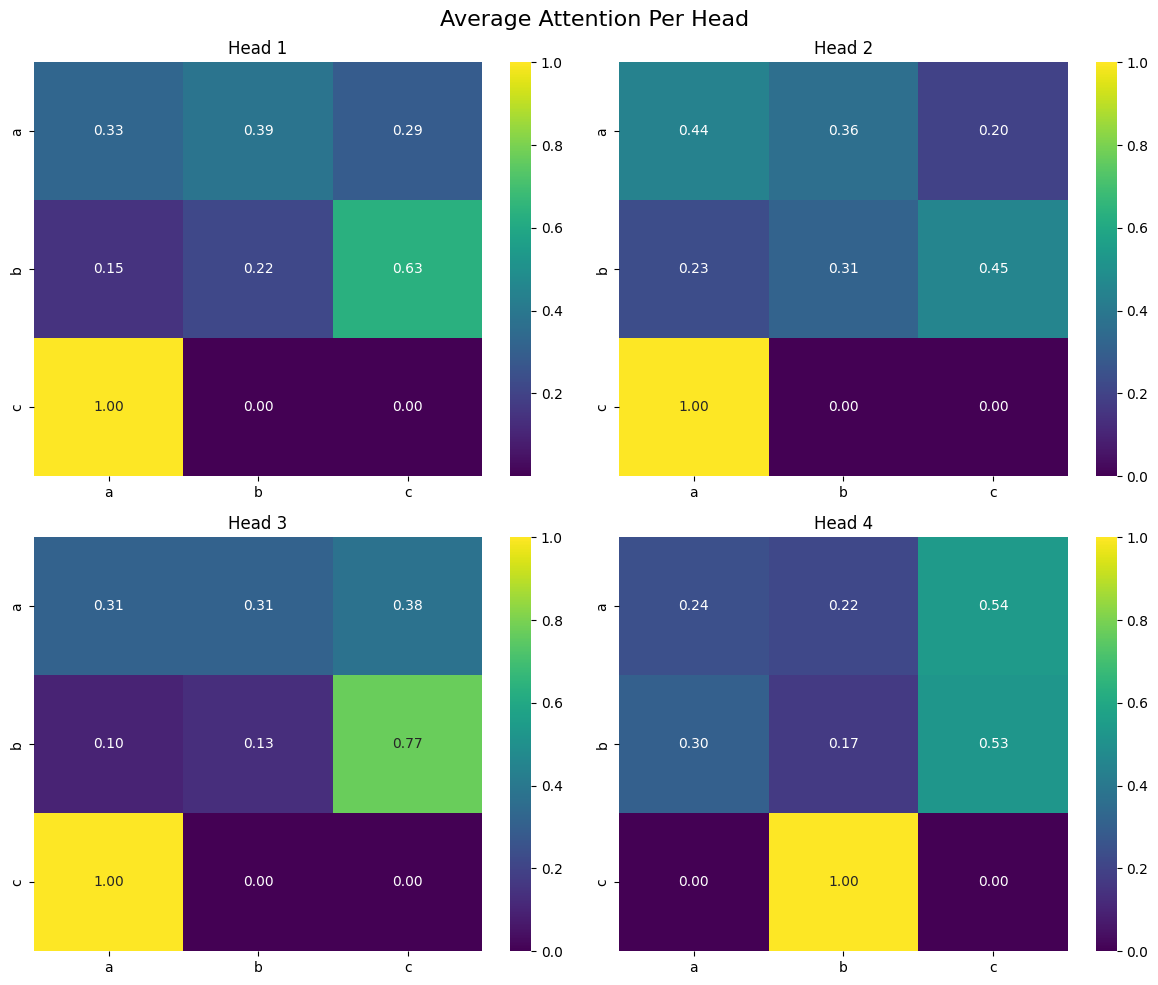

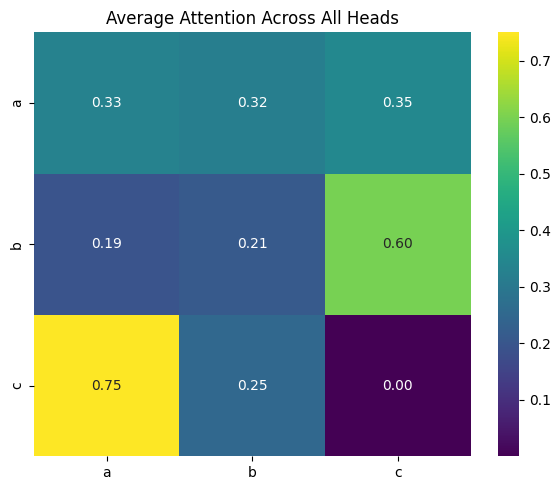

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import math

# Compute and plot average attention across all heads and all samples
def compute_average_attention(model, dataset, batch_size=32):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_attn = []

    def hook(module, input, output):
        _, attn_weights = output  # Extract attention weights
        all_attn.append(attn_weights.detach())

    # Hook into the attention layer
    handle = model.attn.register_forward_hook(hook)

    with torch.no_grad():
        for x, _ in dataloader:
            model(x)

    handle.remove()


    all_attn = torch.cat(all_attn, dim=0)  
    
    # Average over samples and heads
    avg_attn = all_attn.mean(dim=0).mean(dim=0)  

    plt.figure(figsize=(6, 5))
    sns.heatmap(avg_attn.numpy(), annot=True, fmt=".2f",
                cmap='viridis', cbar=True,
                xticklabels=['a', 'b', 'c'],
                yticklabels=['a', 'b', 'c'])
    plt.title("Average Attention Across All Heads and Samples")
    plt.show()

    return avg_attn

# Compute and plot average attention separately per head
def compute_average_attention_per_head(model, dataset, batch_size=32):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_attn = []

    def hook(module, input, output):
        _, attn_weights = output
        all_attn.append(attn_weights.detach())

    handle = model.attn.register_forward_hook(hook)

    with torch.no_grad():
        for x, _ in dataloader:
            model(x)

    handle.remove()

    all_attn = torch.cat(all_attn, dim=0)  
    per_head_avg = all_attn.mean(dim=0)    

    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle("Average Attention Per Head", fontsize=16)
    axes = axes.flatten()

    for h in range(per_head_avg.shape[0]):
        sns.heatmap(per_head_avg[h].numpy(), annot=True, fmt=".2f",
                    cmap='viridis', cbar=True,
                    xticklabels=['a', 'b', 'c'],
                    yticklabels=['a', 'b', 'c'],
                    ax=axes[h])
        axes[h].set_title(f"Head {h + 1}")

    plt.tight_layout()
    plt.show()

    return per_head_avg

# Plot average attention across heads (final summary)
def plot_average_attention_across_heads(avg_per_head):
    avg_across_heads = avg_per_head.mean(dim=0)  

    plt.figure(figsize=(6, 5))
    sns.heatmap(avg_across_heads.numpy(), annot=True, fmt=".2f",
                cmap='viridis', cbar=True,
                xticklabels=['a', 'b', 'c'],
                yticklabels=['a', 'b', 'c'])
    plt.title("Average Attention Across All Heads")
    plt.tight_layout()
    plt.show()


per_head_avg=compute_average_attention_per_head(model_B, dataset)
plot_average_attention_across_heads(per_head_avg)

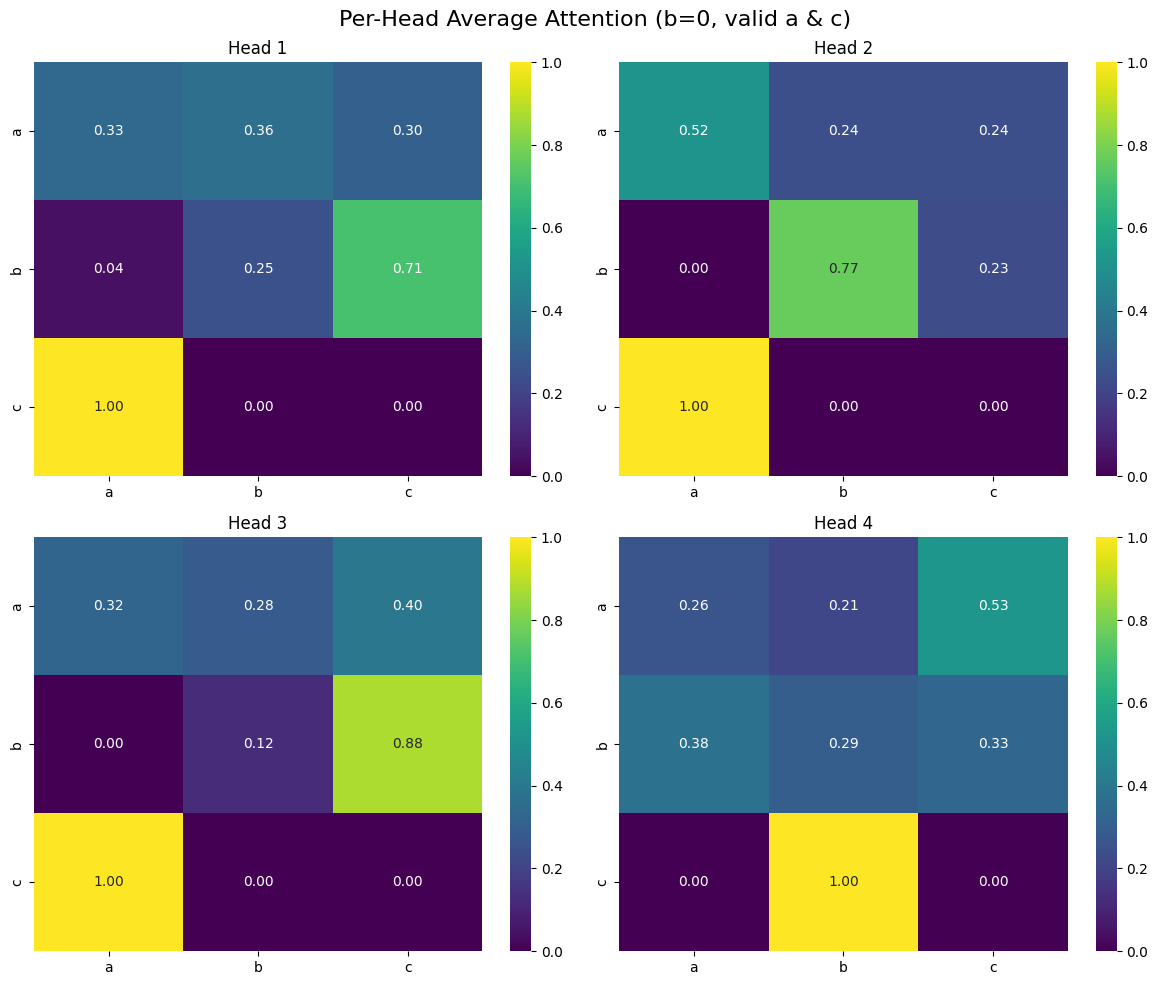

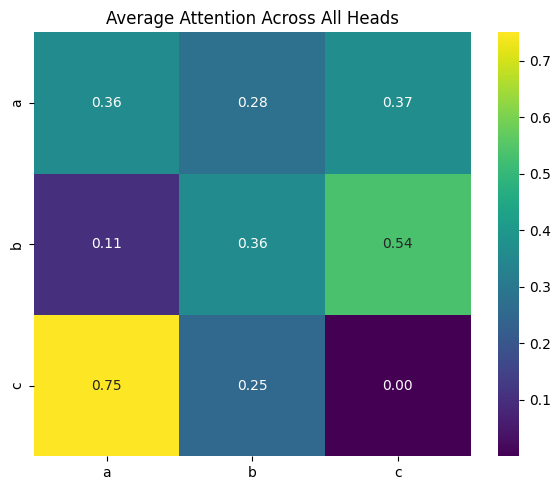

In [7]:
def per_head_attention_b0_c_var(model, dataset):
    model.eval()
    vocab = dataset.vocab
    reverse_vocab = {v: k for k, v in vocab.items()}

    all_attn_by_head = []

    # Iterate over valid (a, c) pairs with b = 0
    for a in range(-13, 14):
        if a == 0:
            continue
        for c in range(-13, 14):
            b = 0
            D = b**2 - 4 * a * c
            if D < 0:
                continue

            try:
                x_vals = [vocab[str(a)], vocab[str(b)], vocab[str(c)]]
            except KeyError:
                continue  # Skip if any token not in vocab

            x = torch.tensor(x_vals, dtype=torch.long).unsqueeze(0)  

            captured = []

            # Hook to capture attention weights
            def hook(module, input, output):
                _, attn_weights = output
                captured.append(attn_weights.detach().squeeze(0))  

            handle = model.attn.register_forward_hook(hook)

            with torch.no_grad():
                _ = model(x)

            handle.remove()

            if captured:
                all_attn_by_head.append(captured[0])

    if not all_attn_by_head:
        print("No valid (a, c) pairs found.")
        return

    
    all_attn_by_head = torch.stack(all_attn_by_head)
    avg_per_head = all_attn_by_head.mean(dim=0)

    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle("Per-Head Average Attention (b=0, valid a & c)", fontsize=16)
    axes = axes.flatten()

    for h in range(avg_per_head.shape[0]):
        sns.heatmap(avg_per_head[h].numpy(), annot=True, fmt=".2f",
                    cmap='viridis', cbar=True,
                    xticklabels=['a', 'b', 'c'],
                    yticklabels=['a', 'b', 'c'],
                    ax=axes[h])
        axes[h].set_title(f"Head {h + 1}")

    plt.tight_layout()
    plt.show()

    return avg_per_head



avg_per_head_b0 = per_head_attention_b0_c_var(model_B, dataset)
plot_average_attention_across_heads(avg_per_head_b0)


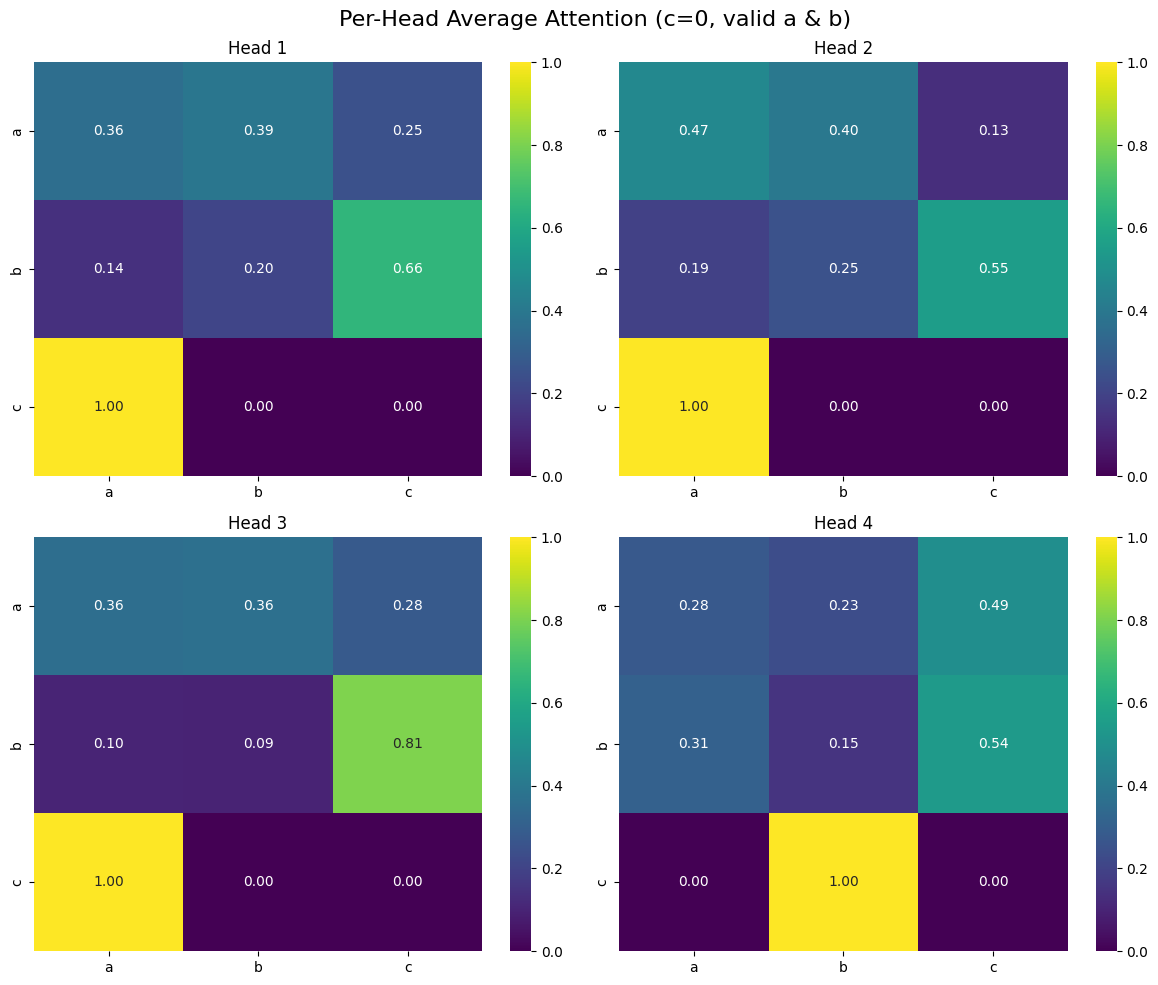

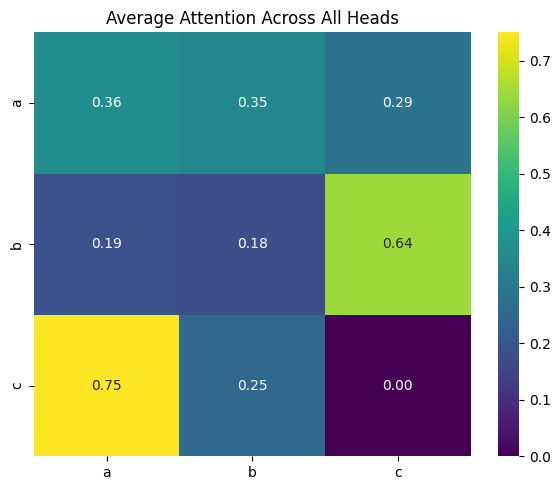

In [8]:
def per_head_attention_c0_ab_var(model, dataset):
    model.eval()
    vocab = dataset.vocab
    reverse_vocab = {v: k for k, v in vocab.items()}

    all_attn_by_head = []

    # Loop through all valid (a, b) combinations where c = 0
    for a in range(-13, 14):
        if a == 0:
            continue  
        for b in range(-13, 14):
            c = 0  

            try:
                x_vals = [vocab[str(a)], vocab[str(b)], vocab[str(c)]]
            except KeyError:
                continue  # Skip if token missing from vocab

            x = torch.tensor(x_vals, dtype=torch.long).unsqueeze(0)  

            captured = []

            
            def hook(module, input, output):
                _, attn_weights = output
                captured.append(attn_weights.detach().squeeze(0))  

            handle = model.attn.register_forward_hook(hook)

            with torch.no_grad():
                _ = model(x)  

            handle.remove()

            if captured:
                all_attn_by_head.append(captured[0])  

    if not all_attn_by_head:
        print("No valid samples found.")
        return

    
    all_attn_by_head = torch.stack(all_attn_by_head) 
    avg_per_head = all_attn_by_head.mean(dim=0)       #

    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle("Per-Head Average Attention (c=0, valid a & b)", fontsize=16)
    axes = axes.flatten()

    for h in range(avg_per_head.shape[0]):
        sns.heatmap(avg_per_head[h].numpy(), annot=True, fmt=".2f",
                    cmap='viridis', cbar=True,
                    xticklabels=['a', 'b', 'c'],
                    yticklabels=['a', 'b', 'c'],
                    ax=axes[h])
        axes[h].set_title(f"Head {h + 1}")

    plt.tight_layout()
    plt.show()

    return avg_per_head



avg_per_head_c0 = per_head_attention_c0_ab_var(model_B, dataset)
plot_average_attention_across_heads(avg_per_head_c0)


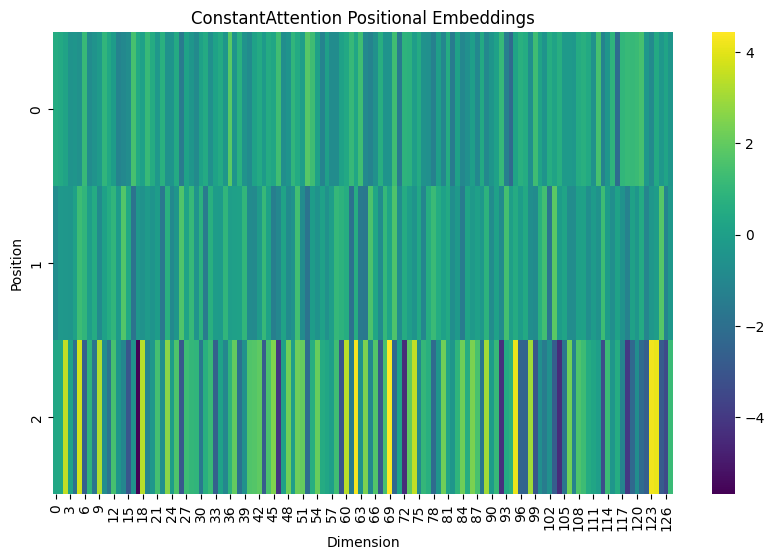

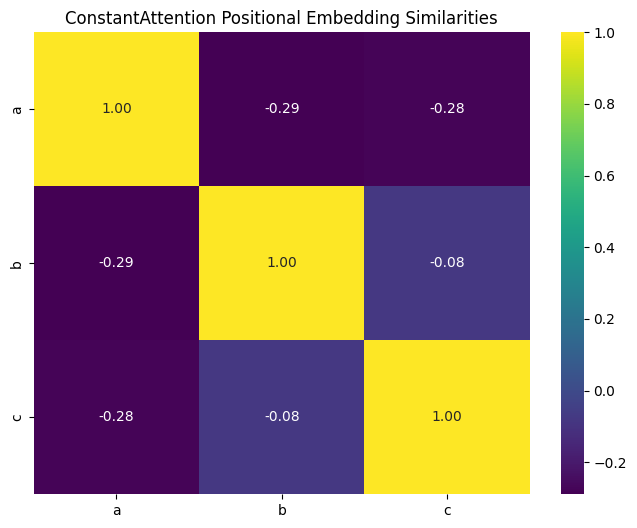

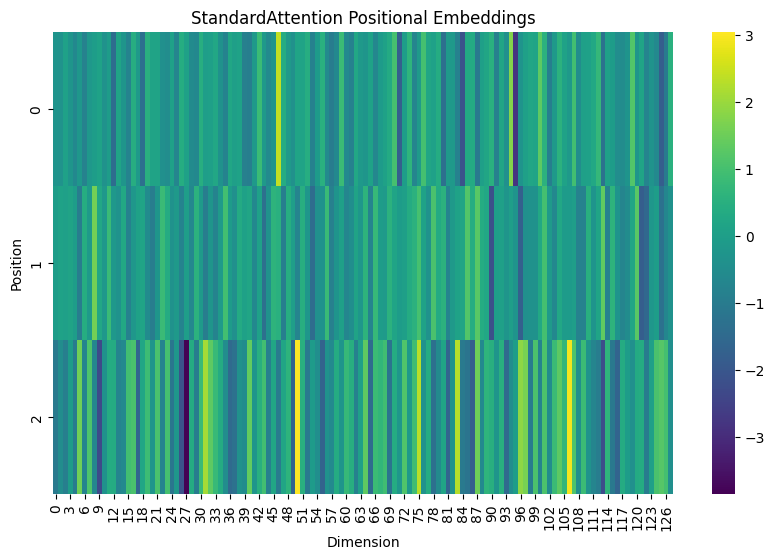

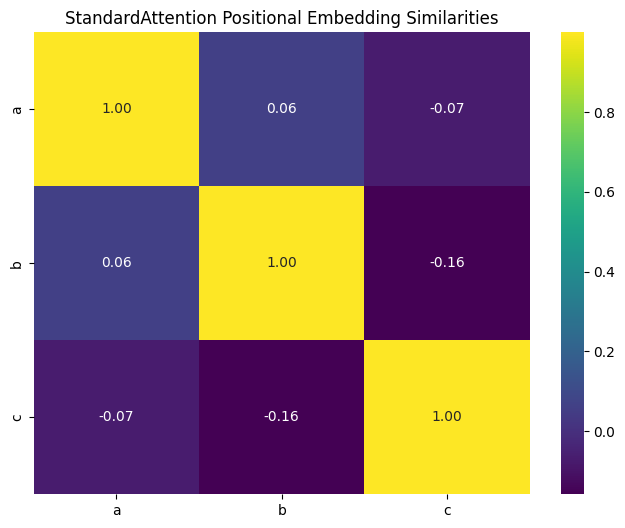

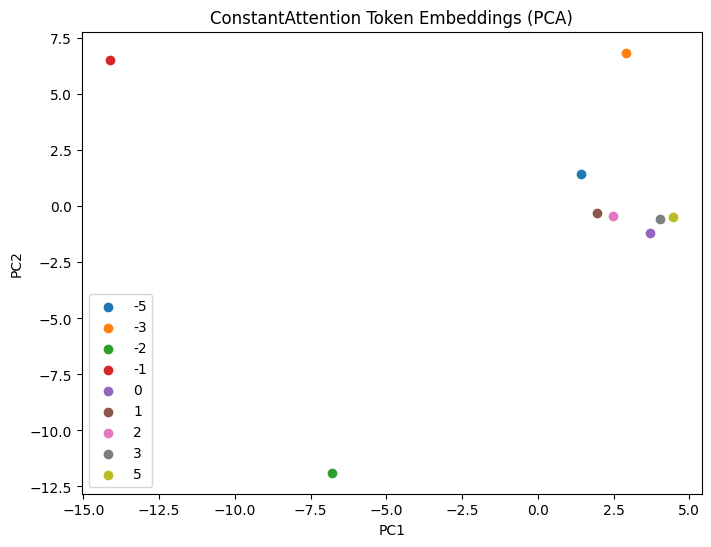

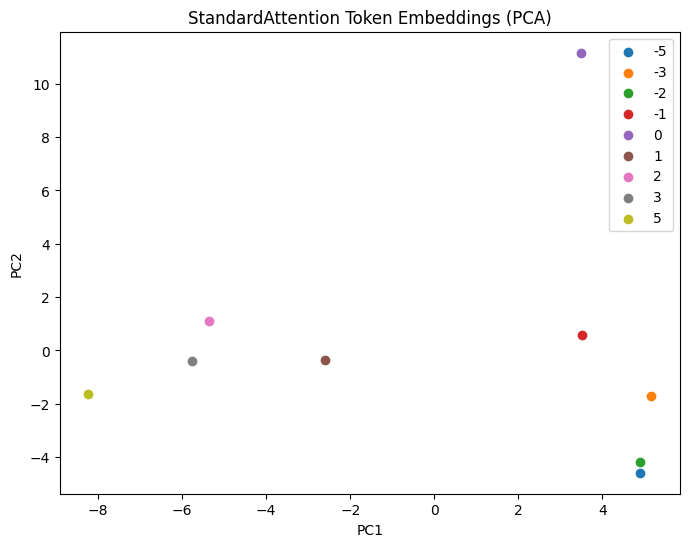

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

def analyze_positional_embeddings(models):
    
    for name, model in models.items():
        if hasattr(model, 'position_embedding'):
            pos_emb = model.position_embedding.detach().numpy()
            
            plt.figure(figsize=(10, 6))
            sns.heatmap(pos_emb, cmap='viridis')
            plt.title(f'{name} Positional Embeddings')
            plt.xlabel('Dimension')
            plt.ylabel('Position')
            plt.show()
            
            # Cosine similarity between positions
            
            sim_matrix = cosine_similarity(pos_emb)
            
            plt.figure(figsize=(8, 6))
            sns.heatmap(sim_matrix, annot=True, fmt='.2f', cmap='viridis',
                        xticklabels=['a', 'b', 'c'],
                        yticklabels=['a', 'b', 'c'])
            plt.title(f'{name} Positional Embedding Similarities')
            plt.show()

def analyze_token_embeddings(models, dataset):
    for name, model in models.items():
        if hasattr(model, 'token_embedding'):
            
            coeffs = [-5, -3, -2, -1, 0, 1, 2, 3, 5]
            indices = [dataset.vocab[str(c)] for c in coeffs]
            embeddings = model.token_embedding(torch.tensor(indices)).detach().numpy()
            
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            reduced = pca.fit_transform(embeddings)
            
            plt.figure(figsize=(8, 6))
            for i, c in enumerate(coeffs):
                plt.scatter(reduced[i, 0], reduced[i, 1], label=str(c))
            plt.legend()
            plt.title(f'{name} Token Embeddings (PCA)')
            plt.xlabel('PC1')
            plt.ylabel('PC2')
            plt.show()
models = {
    'ConstantAttention': model_A,
    'StandardAttention': model_B
}

analyze_positional_embeddings(models)
analyze_token_embeddings(models, dataset)

Constant Attention Transformer:

Sample: a=12, b=5, c=-12
True roots: [ 0.81313753 -1.2298043 ]


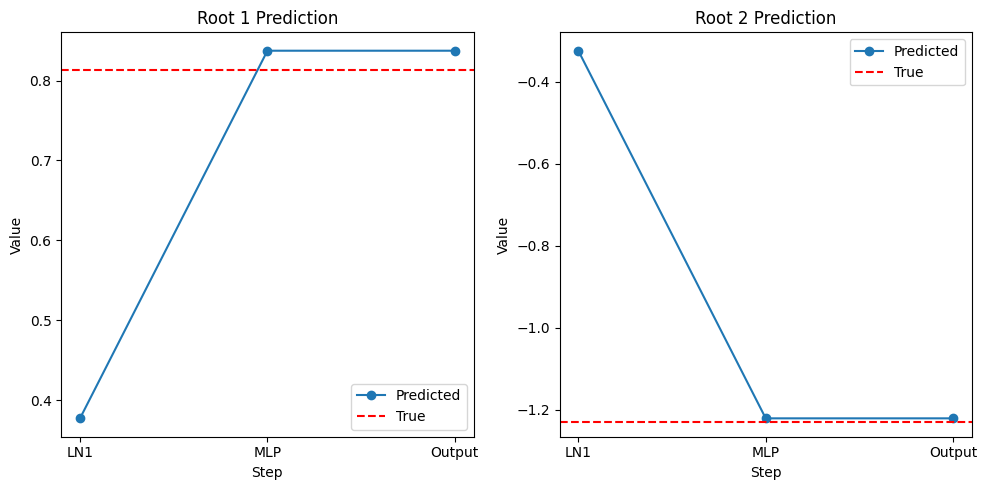


Standard Attention Transformer:

Sample: a=-1, b=1, c=3
True roots: [-1.3027756  2.3027756]


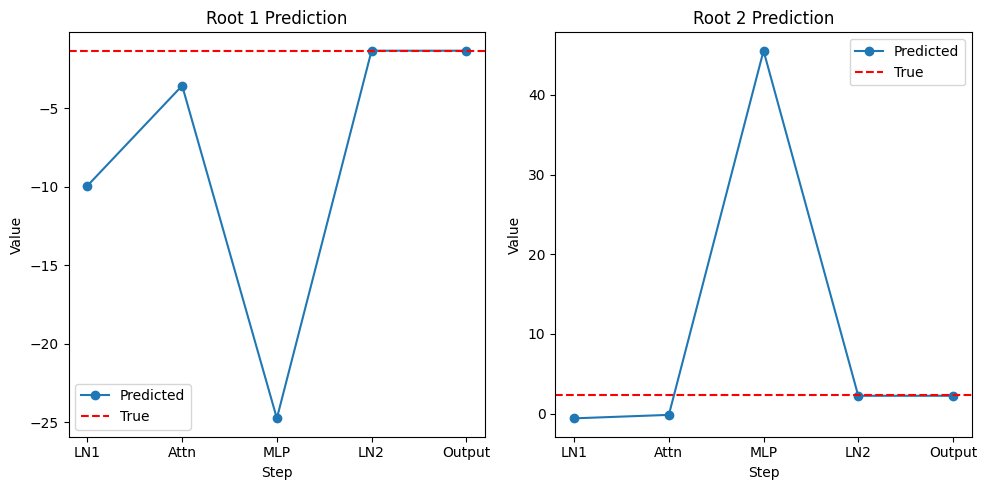

In [21]:
def logit_lens_analysis(model, dataset, num_samples=1):
    # Create reverse vocabulary
    reverse_vocab = {v: k for k, v in dataset.vocab.items()}
    
    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    samples = [dataset[i] for i in indices]
    
    # Store predictions at each layer
    all_layer_preds = []
    if isinstance(model, ConstantAttentionTransformer):
        substep_labels = ["LN1", "MLP", "Output"]  # ConstantAttentionTransformer
    else:
        substep_labels = ["LN1", "Attn", "MLP", "LN2", "Output"]  # StandardAttentionTransfo
    # Hook function to capture intermediate outputs
    def add_hooks(module):
        hooks = []
        substep_labels = []
        # Capture output after attention
        def attn_hook(module, input, output):
            
            hidden_states = output[0]
            preds = model.output_head(hidden_states[:,-1,:]) 
            all_layer_preds.append(preds.detach())
            return output
        
        # Capture output after MLP
        def mlp_hook(module, input, output):
            preds = model.output_head(output[:,-1,:])
            all_layer_preds.append(preds.detach())
            return output
        
        # Register hooks based on model type
        if isinstance(model, ConstantAttentionTransformer):
            
            hooks.append(model.ln1.register_forward_hook(
                lambda m, i, o: all_layer_preds.append(model.output_head(o[:,-1,:].detach()))))   
            hooks.append(model.mlp[-1].register_forward_hook(mlp_hook))
        
            
            
        elif isinstance(model, StandardAttentionTransformer):
            
            hooks.append(model.ln1.register_forward_hook(
                lambda m, i, o: all_layer_preds.append(model.output_head(o[:,-1,:].detach()))))
            hooks.append(model.attn.register_forward_hook(attn_hook))
            hooks.append(model.mlp[-1].register_forward_hook(mlp_hook))
            
            hooks.append(model.ln2.register_forward_hook(
                lambda m, i, o: all_layer_preds.append(model.output_head(o[:,-1,:].detach()))))
        
        return hooks
    
    # Analyze samples
    for x, y in samples:
        all_layer_preds = []  
        
        # Register hooks
        hooks = add_hooks(model)
        
        # Forward pass
        with torch.no_grad():
            final_pred = model(x.unsqueeze(0))
            all_layer_preds.append(final_pred.detach())  # Final prediction
        
        # Remove hooks
        for hook in hooks:
            hook.remove()
        
        
        layer_preds = torch.stack(all_layer_preds).squeeze(1).numpy()
        true_roots = y.numpy()
        
        
        print(f"\nSample: a={reverse_vocab[x[0].item()]}, "
              f"b={reverse_vocab[x[1].item()]}, "
              f"c={reverse_vocab[x[2].item()]}")
        print(f"True roots: {true_roots}")
        
        
        plt.figure(figsize=(10, 5))
        
        # Root 1
        plt.subplot(1, 2, 1)
        plt.plot(layer_preds[:, 0], 'o-', label='Predicted')
        plt.axhline(true_roots[0], color='r', linestyle='--', label='True')
        plt.title("Root 1 Prediction")
        plt.xlabel("Step")
        plt.xticks(range(len(substep_labels)), substep_labels)
        plt.ylabel("Value")
        plt.legend()
        
        # Root 2
        plt.subplot(1, 2, 2)
        plt.plot(layer_preds[:, 1], 'o-', label='Predicted')
        plt.axhline(true_roots[1], color='r', linestyle='--', label='True')
        plt.title("Root 2 Prediction")
        plt.xlabel("Step")
        plt.xticks(range(len(substep_labels)), substep_labels)
        plt.ylabel("Value")
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        


print("Constant Attention Transformer:")
logit_lens_analysis(model_A, dataset)

print("\nStandard Attention Transformer:")
logit_lens_analysis(model_B, dataset)

Logit Lens Analysis on Both Models:

Sample: a=8, b=-4, c=-10
True roots: [ 1.395644   -0.89564395]


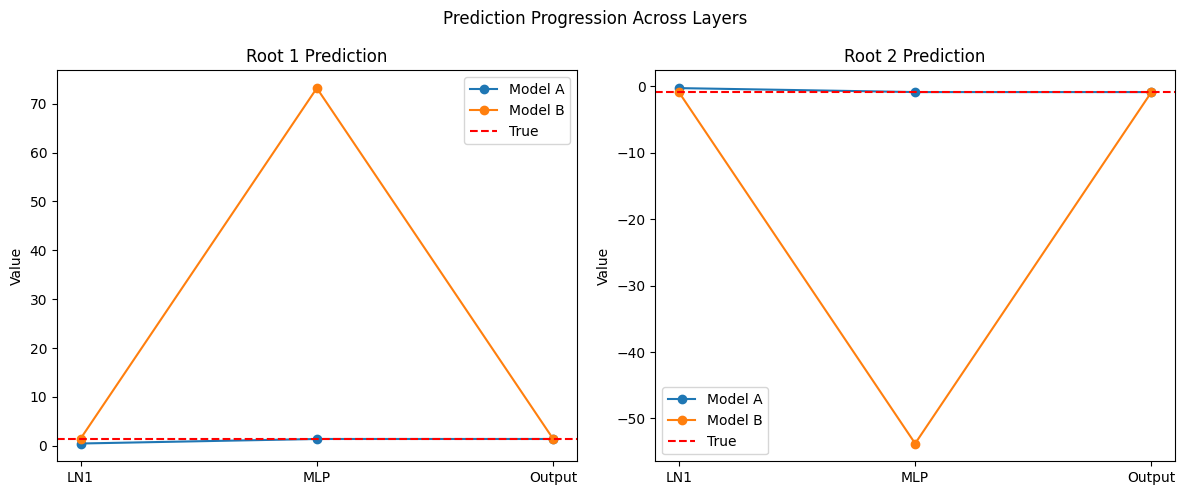

In [22]:
def logit_lens_analysis_overlap(model_a, model_b, dataset, num_samples=1):
    import matplotlib.pyplot as plt

    # Create reverse vocabulary
    reverse_vocab = {v: k for k, v in dataset.vocab.items()}
    
    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    samples = [dataset[i] for i in indices]
    
    substep_labels = ["LN1", "MLP", "Output"]  # Common substeps to both models

    def get_preds_at_substeps(model, x):
        all_layer_preds = []

        def mlp_hook(module, input, output):
            preds = model.output_head(output[:, -1, :])
            all_layer_preds.append(preds.detach())
            return output

        def ln1_hook(module, input, output):
            preds = model.output_head(output[:, -1, :])
            all_layer_preds.append(preds.detach())
            return output

        hooks = []
        hooks.append(model.ln1.register_forward_hook(ln1_hook))
        hooks.append(model.mlp[-1].register_forward_hook(mlp_hook))

        with torch.no_grad():
            final_pred = model(x.unsqueeze(0))
            all_layer_preds.append(final_pred.detach())

        for hook in hooks:
            hook.remove()

        return torch.stack(all_layer_preds).squeeze(1).numpy()

    for x, y in samples:
        preds_a = get_preds_at_substeps(model_a, x)
        preds_b = get_preds_at_substeps(model_b, x)
        true_roots = y.numpy()

        print(f"\nSample: a={reverse_vocab[x[0].item()]}, "
              f"b={reverse_vocab[x[1].item()]}, "
              f"c={reverse_vocab[x[2].item()]}")
        print(f"True roots: {true_roots}")

        plt.figure(figsize=(12, 5))

        # Root 1
        plt.subplot(1, 2, 1)
        plt.plot(preds_a[:, 0], 'o-', label='Model A')
        plt.plot(preds_b[:, 0], 'o-', label='Model B')
        plt.axhline(true_roots[0], color='r', linestyle='--', label='True')
        plt.title("Root 1 Prediction")
        plt.xticks(range(len(substep_labels)), substep_labels)
        plt.ylabel("Value")
        plt.legend()

        # Root 2
        plt.subplot(1, 2, 2)
        plt.plot(preds_a[:, 1], 'o-', label='Model A')
        plt.plot(preds_b[:, 1], 'o-', label='Model B')
        plt.axhline(true_roots[1], color='r', linestyle='--', label='True')
        plt.title("Root 2 Prediction")
        plt.xticks(range(len(substep_labels)), substep_labels)
        plt.ylabel("Value")
        plt.legend()

        plt.suptitle("Prediction Progression Across Layers")
        plt.tight_layout()
        plt.show()
print("Logit Lens Analysis on Both Models:")
logit_lens_analysis_overlap(model_A, model_B, dataset)

Constant Attention Transformer Accuracy: 0.10%


Standard Attention Transformer Accuracy: 0.95%


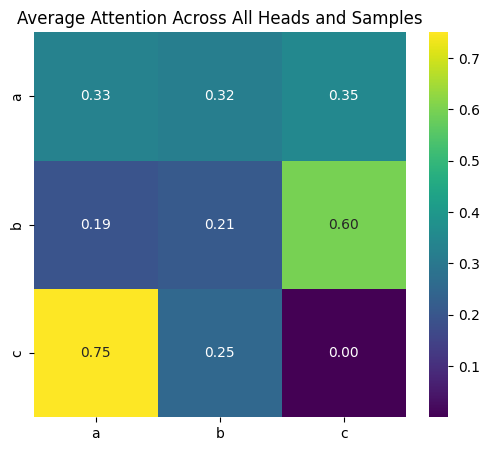

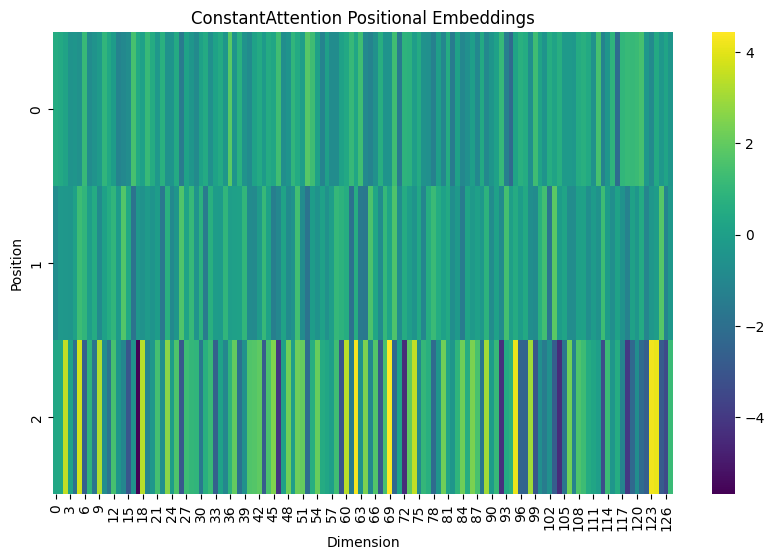

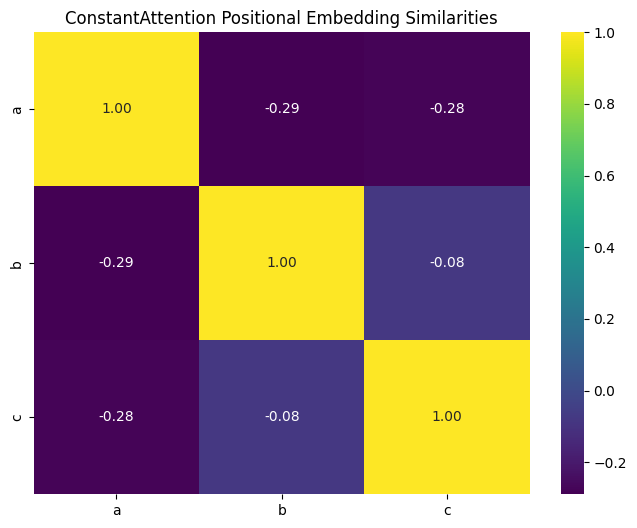

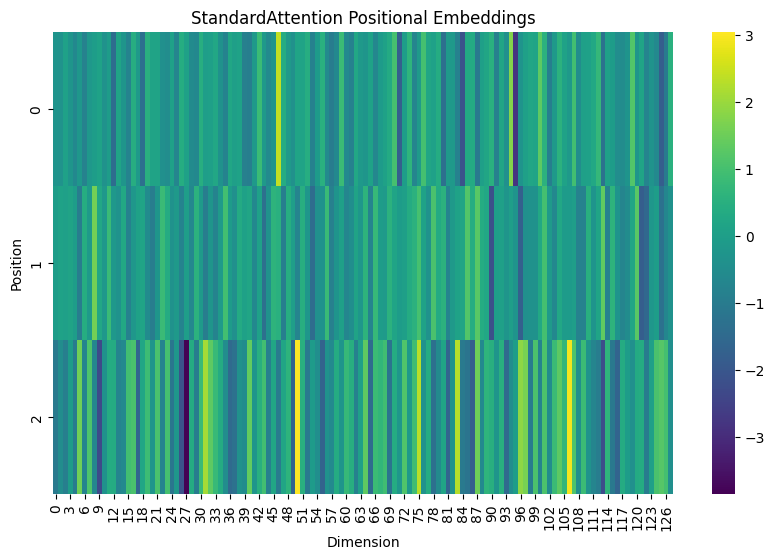

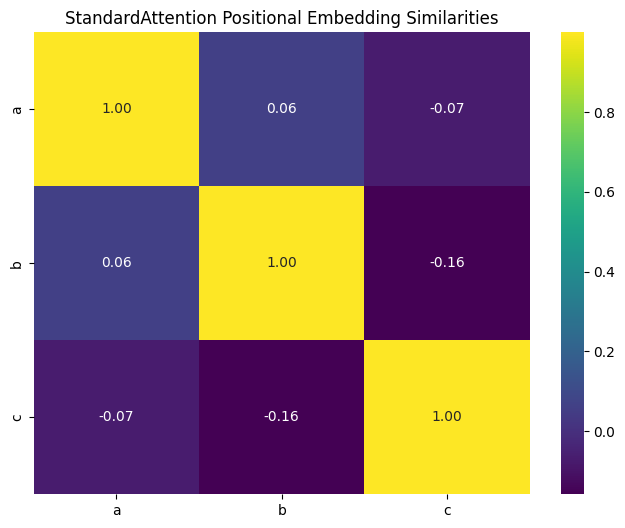

In [23]:
import copy
# Remove MLP
def ablate_mlp(model):
    if hasattr(model, 'mlp'):
        model.mlp = nn.Identity()
    return model

mlp_model_A = copy.deepcopy(model_A)
mlp_model_B = copy.deepcopy(model_B) 

ablate_mlp(mlp_model_A)
ablate_mlp(mlp_model_B)
mlp_models = {
    'ConstantAttention': mlp_model_A,
    'StandardAttention': mlp_model_B
}

print(f"Constant Attention Transformer Accuracy: {evaluate_model(mlp_model_A, test_dataloader):.2%}")
print(f"Standard Attention Transformer Accuracy: {evaluate_model(mlp_model_B, test_dataloader):.2%}")
compute_average_attention(mlp_model_B,dataset)
analyze_positional_embeddings(mlp_models)


Constant Attention Transformer Accuracy: 84.10%
Standard Attention Transformer Accuracy: 0.15%


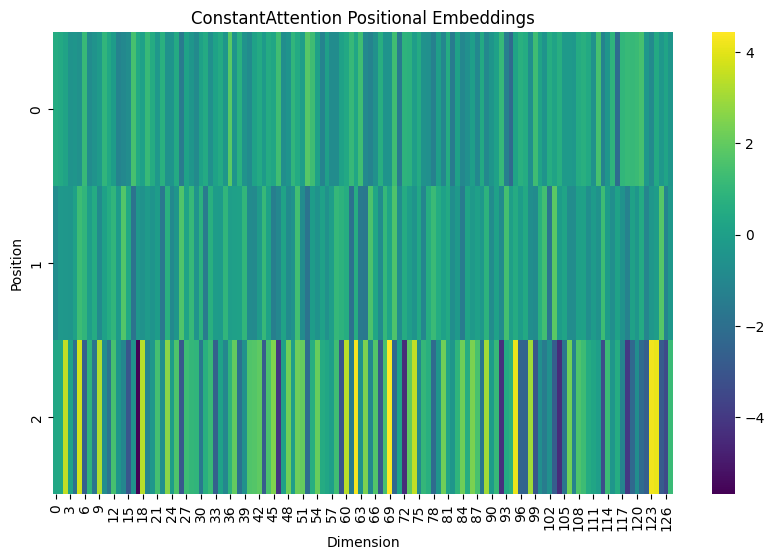

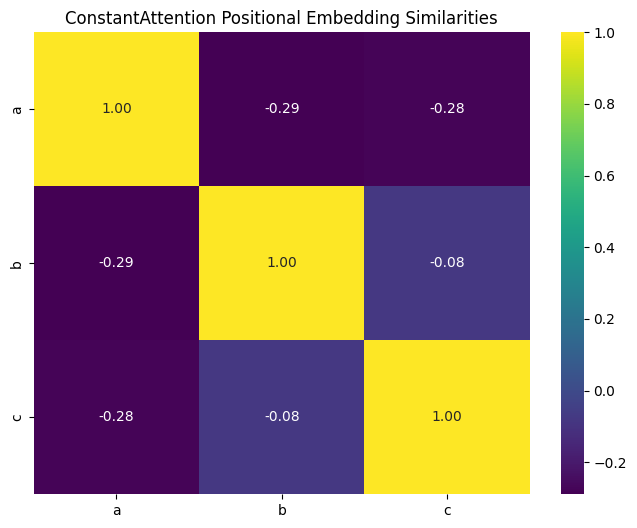

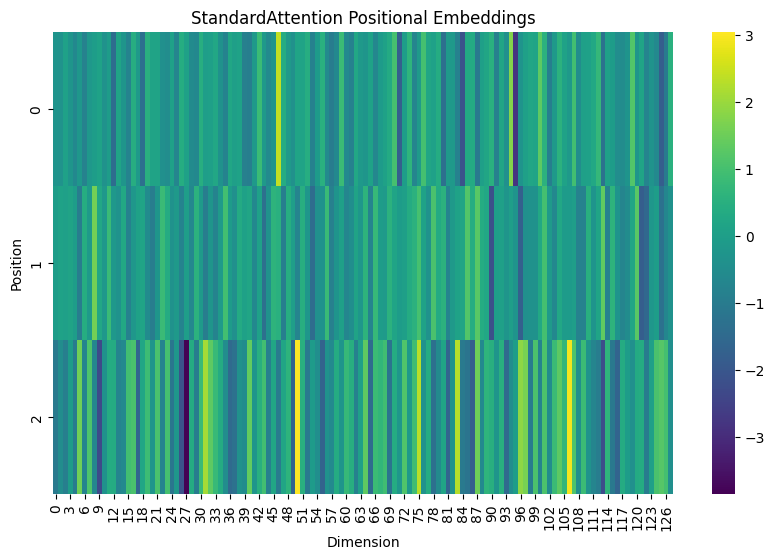

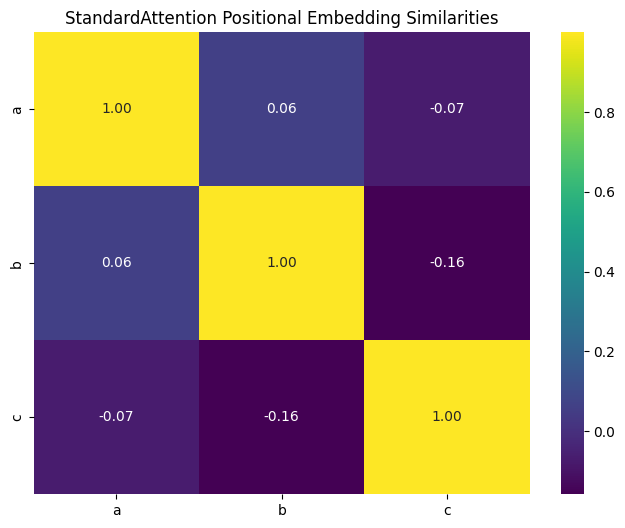

Constant Attention Transformer:

Sample: a=4, b=-13, c=9
True roots: [2.25 1.  ]


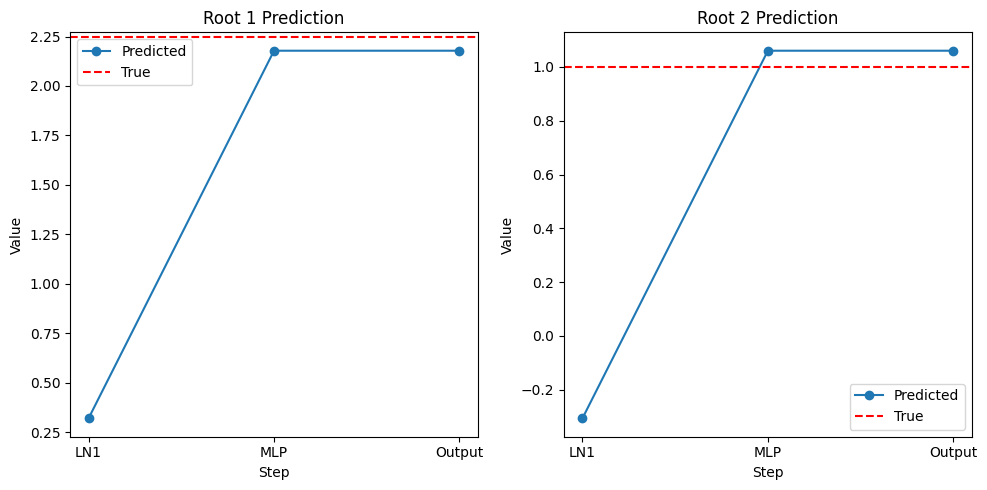


Standard Attention Transformer:

Sample: a=1, b=-8, c=10
True roots: [6.4494896 1.5505103]


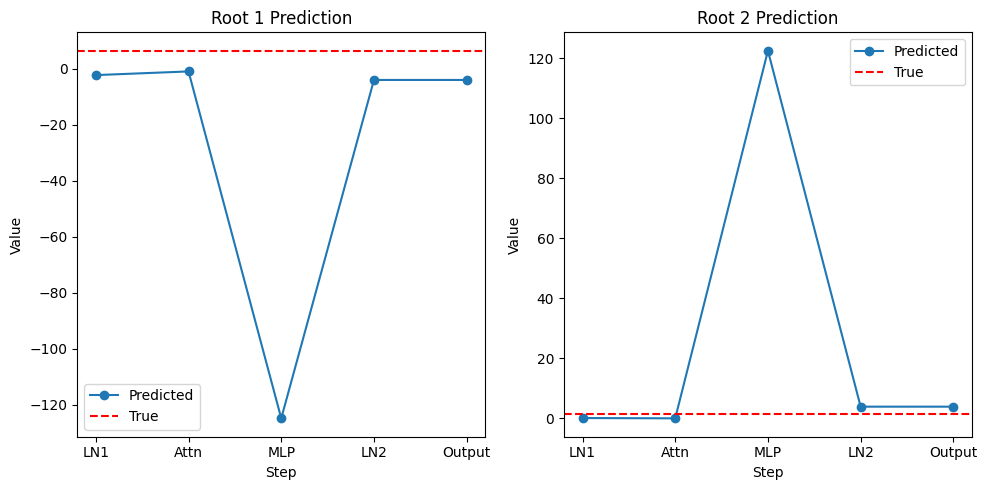

In [24]:
# Remove attention
def ablate_attention(model):
    
    # Case 1: Model B
    if hasattr(model, 'attn') and isinstance(model.attn, nn.MultiheadAttention):
        
        def identity_attention(q, k, v, *args, **kwargs):
            return v, None  
        
        model.attn.forward = identity_attention
    
    # Case 2: Model A
    elif hasattr(model, 'attn_weights'):
        n_positions = model.attn_weights.shape[0]
        model.attn_weights.data = torch.ones(n_positions, n_positions) / n_positions
        model.attn_weights.requires_grad = False

    return model

attn_model_A = copy.deepcopy(model_A)
attn_model_B = copy.deepcopy(model_B)
ablate_attention(attn_model_A)
ablate_attention(attn_model_B)
attn_models = {
    'ConstantAttention': attn_model_A,
    'StandardAttention': attn_model_B
}

print(f"Constant Attention Transformer Accuracy: {evaluate_model(attn_model_A, test_dataloader):.2%}")
print(f"Standard Attention Transformer Accuracy: {evaluate_model(attn_model_B, test_dataloader):.2%}")

analyze_positional_embeddings(attn_models)
print("Constant Attention Transformer:")
logit_lens_analysis(attn_model_A, dataset)

print("\nStandard Attention Transformer:")
logit_lens_analysis(attn_model_B, dataset)

Constant Attention Transformer Accuracy: 0.00%
Standard Attention Transformer Accuracy: 0.05%


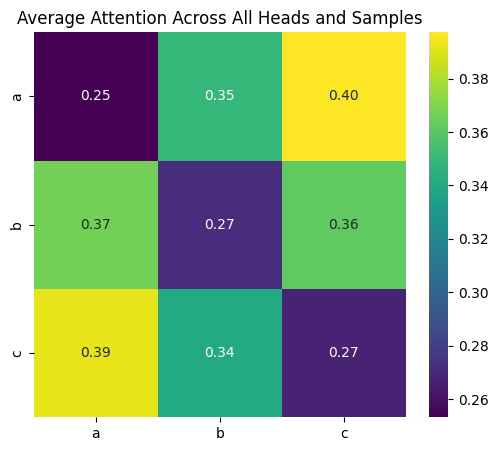

Constant Attention Transformer:

Sample: a=10, b=11, c=-2
True roots: [ 0.15887235 -1.2588724 ]


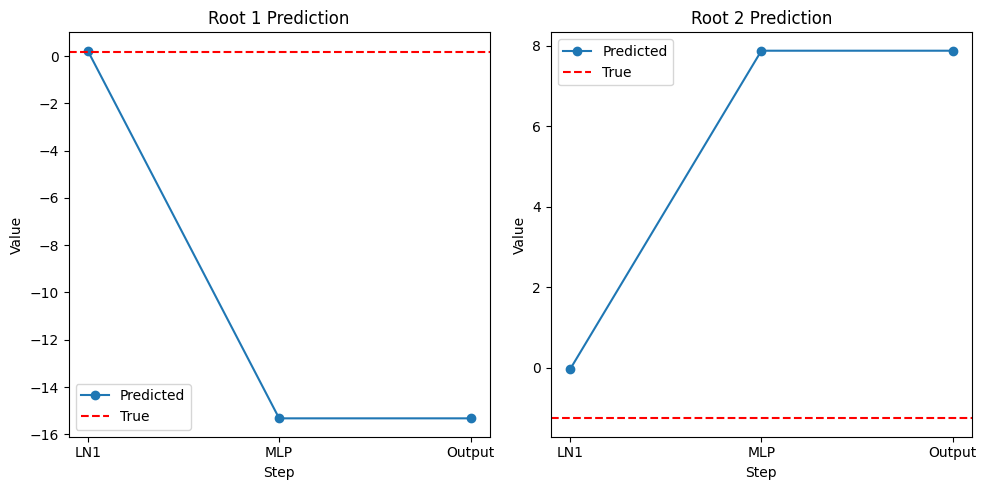


Standard Attention Transformer:

Sample: a=4, b=-12, c=-5
True roots: [ 3.3708286 -0.3708287]


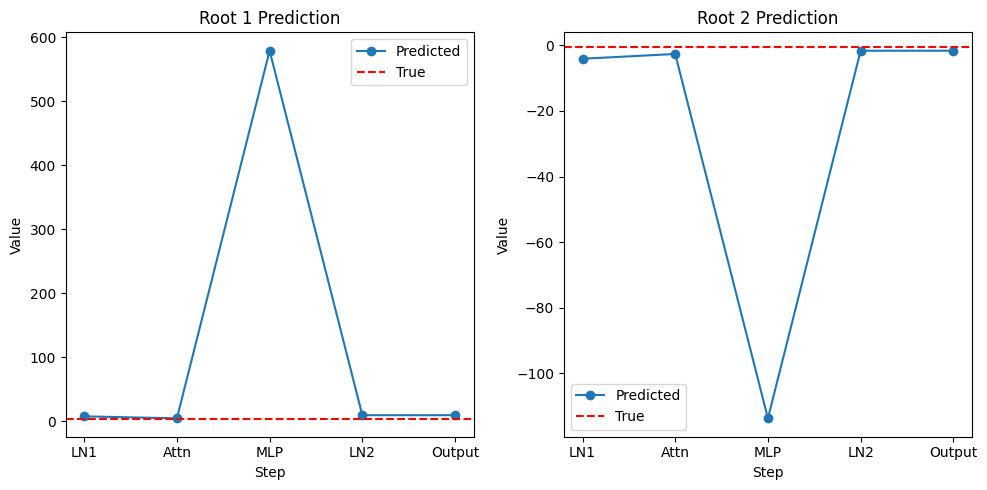

In [25]:
# Remove positional embeddings
def ablate_pos_embed(model):
    if hasattr(model, 'position_embedding'):
        model.position_embedding.requires_grad_(False)
        with torch.no_grad():
            model.position_embedding.zero_()
    return model
pos_model_A = copy.deepcopy(model_A)
pos_model_B = copy.deepcopy(model_B)

ablate_pos_embed(pos_model_A)
ablate_pos_embed(pos_model_B)

pos_models = {
    'ConstantAttention': pos_model_A,
    'StandardAttention': pos_model_B
}



print(f"Constant Attention Transformer Accuracy: {evaluate_model(pos_model_A, test_dataloader):.2%}")
print(f"Standard Attention Transformer Accuracy: {evaluate_model(pos_model_B, test_dataloader):.2%}")
compute_average_attention(pos_model_B,dataset)

print("Constant Attention Transformer:")
logit_lens_analysis(pos_model_A, dataset)

print("\nStandard Attention Transformer:")
logit_lens_analysis(pos_model_B, dataset)

In [26]:
def run_with_patch(model, x_clean, x_corrupt, target_layer, position):
    """Replace activation at `position` in `target_layer` with clean version."""
    clean_acts = {}
    corrupt_acts = {}

    def hook_clean(module, input, output):
        clean_acts["act"] = output.detach()

    def hook_corrupt(module, input, output):
        corrupt_acts["act"] = output.detach()

    # Register hooks
    handle1 = getattr(model, target_layer).register_forward_hook(hook_clean)
    model(x_clean)
    handle1.remove()

    handle2 = getattr(model, target_layer).register_forward_hook(hook_corrupt)
    model(x_corrupt)
    handle2.remove()

    # Replace the corrupted activation at the given position with the clean one
    patched = corrupt_acts["act"].clone()
    patched[:, position, :] = clean_acts["act"][:, position, :]
    return patched
    
x_clean = torch.tensor([dataset.vocab["2"], dataset.vocab["-3"], dataset.vocab["1"]]).unsqueeze(0)  
x_corrupt = torch.tensor([dataset.vocab["1"], dataset.vocab["0"], dataset.vocab["0"]]).unsqueeze(0) 

# Run with patch on model_A 
patched_activations = run_with_patch(
    model=model_A,
    x_clean=x_clean,
    x_corrupt=x_corrupt,
    target_layer="mlp",  # Patching the MLP layer
    position=1          # Patching the second position (coefficient 'b')
)


def compare_patched_predictions(model, x_clean, x_corrupt, layer, position):
    # Get original predictions
    with torch.no_grad():
        clean_out = model(x_clean)  
        corrupt_out = model(x_corrupt)  # 
    
    # Get patched activations
    patched_act = run_with_patch(model, x_clean, x_corrupt, layer, position)
    
    # Forward pass with patched activations
    with torch.no_grad():
        if layer == "mlp":
            
            patched_out = model.output_head(patched_act[:,-1,:]) 
        elif layer == "ln1":
            
            x = patched_act
            ff_out = model.mlp(x)
            x = model.ln2(x + ff_out) 
            patched_out = model.output_head(x[:,-1,:])
    
    print("Clean output:", clean_out)
    print("Corrupt output:", corrupt_out)
    print("Patched output:", patched_out)


compare_patched_predictions(
    model=model_A,
    x_clean=torch.tensor([dataset.vocab["2"], dataset.vocab["-3"], dataset.vocab["1"]]).unsqueeze(0),
    x_corrupt=torch.tensor([dataset.vocab["1"], dataset.vocab["0"], dataset.vocab["0"]]).unsqueeze(0),
    layer="mlp",
    position=0
)

compare_patched_predictions(
    model=model_B,
    x_clean=torch.tensor([dataset.vocab["2"], dataset.vocab["-3"], dataset.vocab["1"]]).unsqueeze(0),  
    x_corrupt=torch.tensor([dataset.vocab["1"], dataset.vocab["0"], dataset.vocab["0"]]).unsqueeze(0),  
    layer="ln1",
    position=0
)

Clean output: tensor([[0.9811, 0.4984]])
Corrupt output: tensor([[-0.0271,  0.0677]])
Patched output: tensor([[-0.0271,  0.0677]])
Clean output: tensor([[0.9742, 0.5124]])
Corrupt output: tensor([[ 0.0394, -0.0131]])
Patched output: tensor([[ 0.0394, -0.0131]])


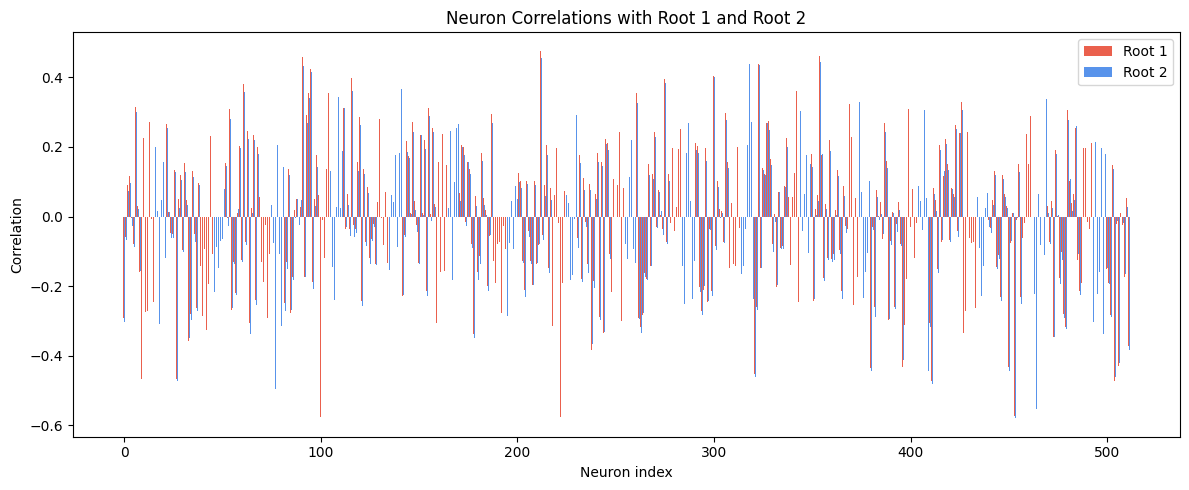

Top 10 Neurons in Model A
Neuron 100: corr = -0.577
Neuron 222: corr = -0.577
Neuron 453: corr = -0.574
Neuron 464: corr = -0.559
Neuron 77: corr = -0.503
Neuron 212: corr = 0.477
Neuron 411: corr = -0.474
Neuron 504: corr = -0.472
Neuron 27: corr = -0.469
Neuron 9: corr = -0.466

Top 10 Neurons in Model B
Neuron 453: corr = -0.581
Neuron 222: corr = -0.581
Neuron 100: corr = -0.574
Neuron 464: corr = -0.555
Neuron 77: corr = -0.495
Neuron 411: corr = -0.481
Neuron 27: corr = -0.472
Neuron 9: corr = -0.464
Neuron 504: corr = -0.463
Neuron 321: corr = -0.461


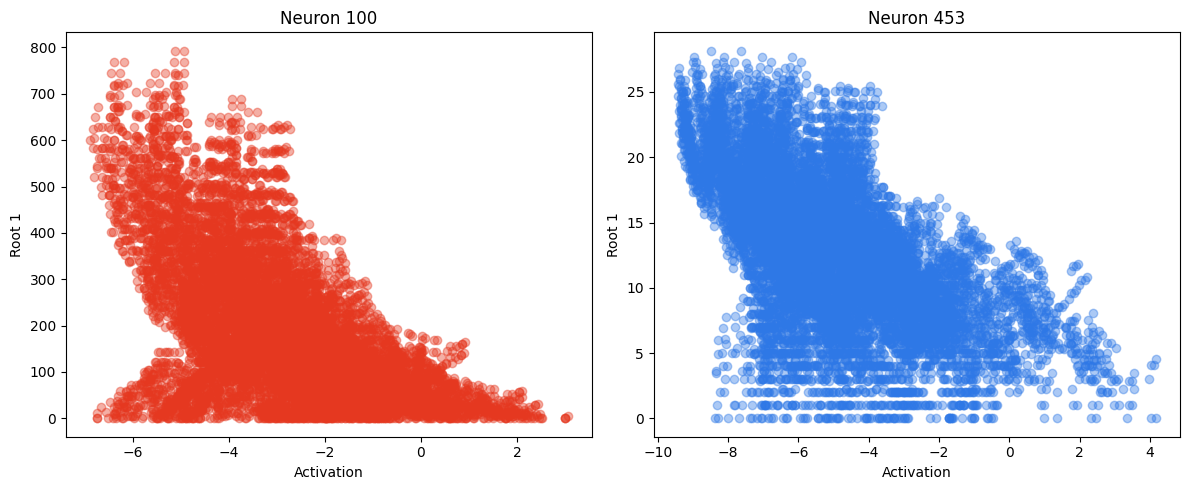

In [31]:
def probe_mlp_activations(model, dataset, feature_fn):
    model.eval()
    activations = []
    targets = []

    def hook(module, input, output):
        # Take the activation of the last token only
        last_token = output[:,-1,:]
        activations.append(last_token.detach().cpu())

    handle = model.mlp[0].register_forward_hook(hook)

    for x, _ in dataset:
        x = x.unsqueeze(0)  
        with torch.no_grad():
            _ = model(x)
            coeffs = x.squeeze(0).numpy()
            targets.append(feature_fn(coeffs))

    handle.remove()

    A = torch.cat(activations, dim=0).numpy() 
    
    Y = np.array(targets).flatten()           

    assert A.shape[0] == Y.shape[0], "Mismatch in number of samples"

    # Correlation between each neuron and the target
    corrs = np.corrcoef(A.T, Y)[-1, :-1]
    return corrs, A, Y


def disc_fn(coeffs):
    a_id, b_id, c_id = coeffs
        
    a = dataset.inv_vocab[a_id]
    b=dataset.inv_vocab[b_id]
    c=dataset.inv_vocab[c_id]
    disc = b**2 - 4*a*c
    return disc

def sqrt_disc_fn(coeffs):
    a_id, b_id, c_id = coeffs
        
    a = dataset.inv_vocab[a_id]
    b=dataset.inv_vocab[b_id]
    c=dataset.inv_vocab[c_id]
    disc = b**2 - 4*a*c
    return np.sqrt(disc)

def root1_fn(coeffs):
    a_id, b_id, c_id = coeffs
        
    a = dataset.inv_vocab[a_id]
    b=dataset.inv_vocab[b_id]
    c=dataset.inv_vocab[c_id]
    disc = b**2 - 4*a*c
    

    return (-b - np.sqrt(disc))/ (2*a)

def root2_fn(coeffs):
    a_id, b_id, c_id = coeffs
        
    a = dataset.inv_vocab[a_id]
    b=dataset.inv_vocab[b_id]
    c=dataset.inv_vocab[c_id]
    disc = b**2 - 4*a*c
    return (-b + np.sqrt(disc))/ (2*a)

def sq_fn(coeffs):
    b = dataset.inv_vocab[coeffs[1]]
    return b**2

def ac_fn(coeffs):
    a, c = dataset.inv_vocab[coeffs[0]], dataset.inv_vocab[coeffs[2]]
    ac_fn =  -(4 * a * c)
    return ac_fn

def fn(coeffs):
    b = dataset.inv_vocab[coeffs[1]]
    a = dataset.inv_vocab[coeffs[0]]
    return (-b)/(2*a)

def neg_b_fn(coeffs):
    b = dataset.inv_vocab[coeffs[1]]
    return -b

def a2_fn(coeffs):
    b = dataset.inv_vocab[coeffs[1]]
    c = dataset.inv_vocab[coeffs[2]]
    return (-b)/(2*dataset.inv_vocab[coeffs[0]]) 

corrs_A, A_A, Y_A = probe_mlp_activations(model_A, dataset, disc_fn)
corrs_B, A_B, Y_B = probe_mlp_activations(model_A, dataset, sqrt_disc_fn)

plt.figure(figsize=(12, 5))
indices = np.arange(len(corrs_A))

plt.bar(indices - 0.2, corrs_A, width=0.4, label="Root 1", alpha=0.8, color='#E53820')
plt.bar(indices + 0.2, corrs_B, width=0.4, label="Root 2", alpha=0.8, color='#2E78E6')

plt.title("Neuron Correlations with Root 1 and Root 2")
plt.xlabel("Neuron index")
plt.ylabel("Correlation")
plt.legend()
plt.tight_layout()
plt.show()
top_k = 10
top_neuron_A = np.argsort(np.abs(corrs_A))[-1]
top_k_neurons_A = np.argsort(np.abs(corrs_A))[-top_k:][::-1]
top_neuron_B = np.argsort(np.abs(corrs_B))[-1]
top_k_neurons_B = np.argsort(np.abs(corrs_B))[-top_k:][::-1]
print("Top 10 Neurons in Model A")
for i in top_k_neurons_A:
    print(f"Neuron {i}: corr = {corrs_A[i]:.3f}")
print('')
print("Top 10 Neurons in Model B")
for i in top_k_neurons_B:
    print(f"Neuron {i}: corr = {corrs_B[i]:.3f}")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(A_A[:, top_neuron_A], Y_A, alpha=0.4, color='#E53820')
axes[0].set_title(f"Neuron {top_neuron_A}")
axes[0].set_xlabel("Activation")
axes[0].set_ylabel("Root 1")

axes[1].scatter(A_B[:, top_neuron_B], Y_B, alpha=0.4, color='#2E78E6')
axes[1].set_title(f"Neuron {top_neuron_B}")
axes[1].set_xlabel("Activation")
axes[1].set_ylabel("Root 1")

plt.tight_layout()
plt.show()


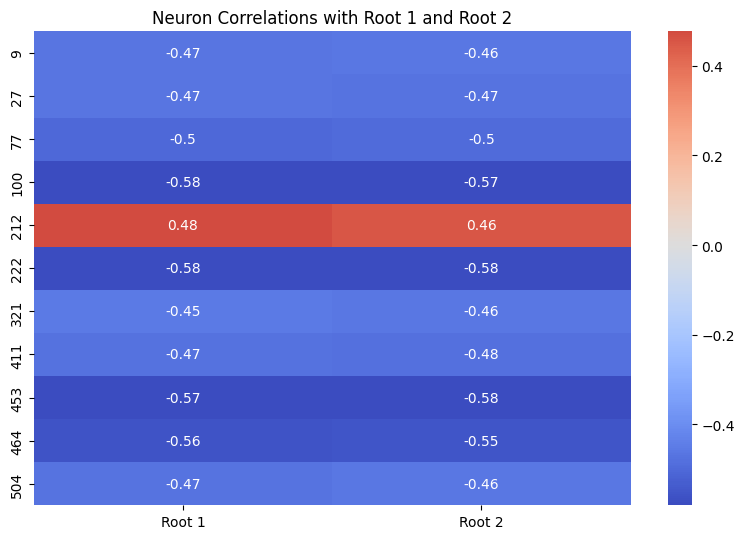

In [32]:
top_neuron_union = sorted(set(top_k_neurons_A.tolist() + top_k_neurons_B.tolist()))
data = np.array([[corrs_A[i], corrs_B[i]] for i in top_neuron_union])

plt.figure(figsize=(8, len(top_neuron_union) * 0.5))
sns.heatmap(data, annot=True, cmap='coolwarm', center=0,
            yticklabels=[f"{i}" for i in top_neuron_union],
            xticklabels=["Root 1", "Root 2"])
plt.title("Neuron Correlations with Root 1 and Root 2")
plt.tight_layout()
plt.show()

In [33]:
import numpy as np
import torch
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def compute_discriminant(a, b, c):
    return b**2 - 4 * a * c

def sqrt_disc(a,b,c):
    return np.sqrt(b**2 - 4 * a * c)

def gradient_alignment(model, token_ids):
    token_ids = token_ids.clone().detach()
    a_ids, b_ids, c_ids = token_ids[:, 0], token_ids[:, 1], token_ids[:, 2]
    
    
    tok_embeds = model.token_embedding(token_ids).detach().requires_grad_(True)
    x = tok_embeds + model.position_embedding  

   
    if isinstance(model, ConstantAttentionTransformer):
        x_norm = model.ln1(x)
        attn_out = torch.einsum('ij,bjd->bid', model.attn_weights, x_norm)
        ff_out = model.mlp(attn_out)
        summary = ff_out[:, -1, :]
        logits = model.output_head(summary)
    elif isinstance(model, StandardAttentionTransformer):
        attn_out, _ = model.attn(x, x, x, need_weights=True, average_attn_weights=False)
        x = model.ln1(x + attn_out)
        ff_out = model.mlp(x)
        x = model.ln2(x + ff_out)
        summary = x[:, -1, :]
        logits = model.output_head(summary)
    else:
        raise ValueError("Unknown model type")

    
    Q = logits[:, 0].sum()
    Q.backward()

   
    grads = tok_embeds.grad  
    
    # Compute theoretical gradients
    a_vals = []
    b_vals = []
    c_vals = []

    for i in list(a_ids.numpy()):
        a_vals.append(dataset.inv_vocab[i])
    for i in list(b_ids.numpy()):
        b_vals.append(dataset.inv_vocab[i])
    for i in list(c_ids.numpy()):
        c_vals.append(dataset.inv_vocab[i])
    
    a_vals = torch.tensor(a_vals).float()
    b_vals = torch.tensor(b_vals).float()
    c_vals = torch.tensor(c_vals).float()
    theoretical = torch.stack([
        -4 * c_vals,
        2 * b_vals,
        -4 * a_vals
    ], dim=1)  

    
    grads_reduced = grads.mean(dim=2)  
    cosine_sims = F.cosine_similarity(grads_reduced, theoretical, dim=1)

    return cosine_sims.mean().item()


def probe_feature(model, inputs, feature_fn):
    with torch.no_grad():
        reps = model.extract_hidden(inputs).mean(dim=1).cpu().numpy() 
        targets = feature_fn(inputs).cpu().numpy()  
    
    targets = targets.reshape(-1, 1)  
    reps = reps.reshape(-1,1)
    reg = LinearRegression().fit(reps, targets)
    return r2_score(targets, reg.predict(reps))
    
def probe_b2(inputs): 
    b_ids = inputs[:, 1]
    b = []
    for i in list(b_ids.numpy()):
            b.append(dataset.inv_vocab[i])
    b = torch.tensor(b)
    return b**2

def probe_4ac(inputs): 
    a_ids, c_ids = inputs[:,0],inputs[:,2]
    
    a = []
    c = []
    for i in list(a_ids.numpy()):
            a.append(dataset.inv_vocab[i])
    for i in list(c_ids.numpy()):
            c.append(dataset.inv_vocab[i])
    a = torch.tensor(a)
    c = torch.tensor(c)
    return 4 * a * c

def probe_discriminant(inputs): 
    a_ids, c_ids = inputs[:,0],inputs[:,2]
    b_ids = inputs[:, 1]
    b = []
    for i in list(b_ids.numpy()):
            b.append(dataset.inv_vocab[i])
    b = torch.tensor(b)
    a = []
    c = []
    for i in list(a_ids.numpy()):
            a.append(dataset.inv_vocab[i])
    for i in list(c_ids.numpy()):
            c.append(dataset.inv_vocab[i])
    a = torch.tensor(a)
    c = torch.tensor(c)
    return compute_discriminant(a, b, c)

def probe_sqrt(inputs): 
    a_ids, c_ids = inputs[:,0],inputs[:,2]
    b_ids = inputs[:, 1]
    b = []
    for i in list(b_ids.numpy()):
            b.append(dataset.inv_vocab[i])
    b = torch.tensor(b)
    a = []
    c = []
    for i in list(a_ids.numpy()):
            a.append(dataset.inv_vocab[i])
    for i in list(c_ids.numpy()):
            c.append(dataset.inv_vocab[i])
    a = torch.tensor(a)
    c = torch.tensor(c)
    return sqrt_disc(a, b, c)

def neg_b_over_2a_probe(inputs):
    a_ids, b_ids = inputs[:,0],inputs[:,1]
    b = []
    a = []
    for i in list(b_ids.numpy()):
            b.append(dataset.inv_vocab[i])
    b = torch.tensor(b)
    for i in list(a_ids.numpy()):
            a.append(dataset.inv_vocab[i])
    a = torch.tensor(a)
    values = (-b) / (2 * a)
    return values

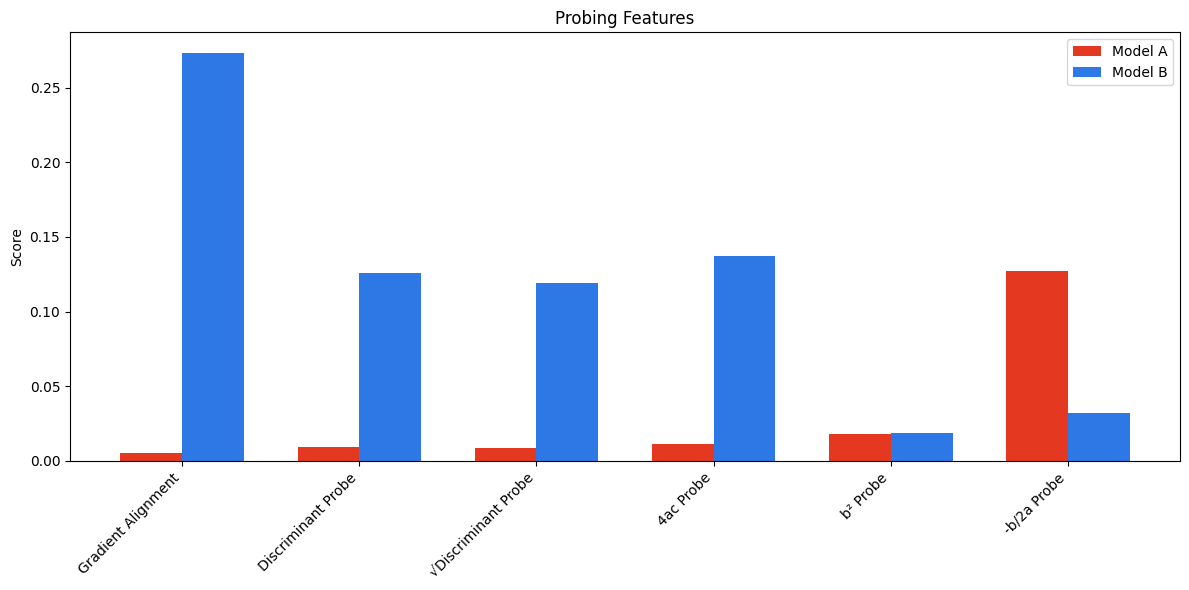

In [34]:
def all(model):
    ga=0
    dr = 0
    dp = 0 
    pb = 0
    pd = 0
    pa = 0
    ap = 0
    sq = 0
    for x,y in dataloader:
        
        ga += gradient_alignment(model, x)
        
        pb += probe_feature(model, x, probe_b2)
        pa += probe_feature(model, x, probe_4ac)
        pd += probe_feature(model, x, probe_discriminant)
        ap += probe_feature(model, x, neg_b_over_2a_probe)
        sq += probe_feature(model, x, probe_sqrt)
        
    return [ga/len(dataloader),pd/len(dataloader),sq/len(dataloader), pa/len(dataloader), pb/len(dataloader), ap/len(dataloader)]


scores_B = all(model_B)
scores_A = all(model_A)
def visualize_probing_scores(scores_A, scores_B, model_labels=("Model A", "Model B")):
    labels = [
        "Gradient Alignment", "Discriminant Probe", "√Discriminant Probe", 
        "4ac Probe", "b² Probe", "-b/2a Probe"
    ]

    
    values = [scores_A, scores_B]
    scores = list(zip(*values))  
    x = range(len(labels))

    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.35
    ax.bar([i - width/2 for i in x], scores_A, width, label=model_labels[0], color='#E53820')
    ax.bar([i + width/2 for i in x], scores_B, width, label=model_labels[1], color='#2E78E6')

    ax.set_ylabel('Score')
    ax.set_title('Probing Features')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()
visualize_probing_scores(scores_A, scores_B)